In [1]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_surf_stat_map
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

### VARIABLES TO SET BEFORE RUNNING
# directory containing subdirectories named fter subject IDs that contain the timeseries and surface files
root_dir = "/home/fralberti/Data/HCP/"
# directory where all intermediate files and the final output will be saved
output_dir = "/home/fralberti/Data/Gradientile/"
# list of IDs of subjects to include in the analyses
subj_id = np.array(["100206","100307","100408","100610","101006",
                    "101107","101309","101410","101915","102008",
                    "102109","102311","102513","102614","102715"])

/home/fralberti/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


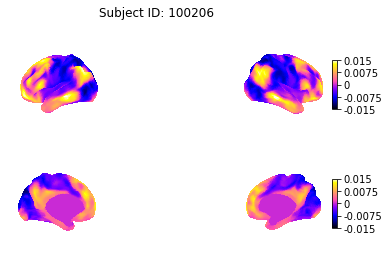

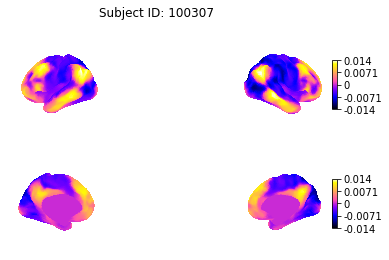

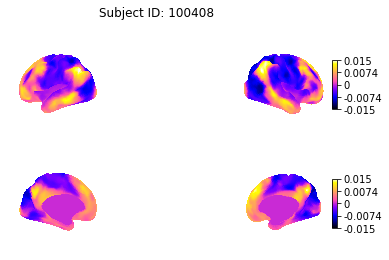

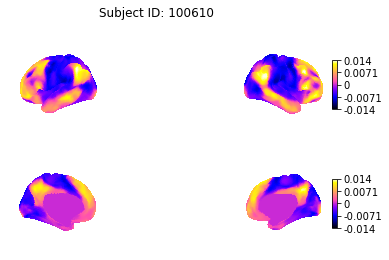

In [2]:
cmap='gnuplot2'
for subj in subj_id[0:4]:
    grad1 = nib.load(f'{output_dir}{subj}.REST1_gcca_smooth6.dscalar.nii')
    fig, axs = plt.subplots(2, 2, figsize=(7,4), subplot_kw={'projection':'3d'}, sharey=True)
    
    for i, hemi in enumerate(['L','R']):
        hemisphere = ['left','right']
        surf = nib.load(f'{root_dir}{subj}/T1w/fsaverage_LR32k/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii')
        
        idx_count = grad1.header.get_index_map(1)[i].index_count
        idx_offset = grad1.header.get_index_map(1)[i].index_offset
        vtx_indices = grad1.header.get_index_map(1)[i].vertex_indices[0:]
        stat_map = np.zeros(surf.agg_data()[0].shape[0])
        stat_map[vtx_indices] = np.array(grad1.get_fdata().squeeze()[0,idx_offset:idx_offset+idx_count])

        plot_surf_stat_map(f'{root_dir}{subj}/T1w/fsaverage_LR32k/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], axes=axs[0,i], colorbar=i, cmap=cmap)
        plot_surf_stat_map(f'{root_dir}{subj}/T1w/fsaverage_LR32k/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], view='medial', axes=axs[1,i],colorbar=i,cmap=cmap)
        fig.suptitle('Subject ID: %s' % subj, fontsize=12)
                
        del surf
    del grad1

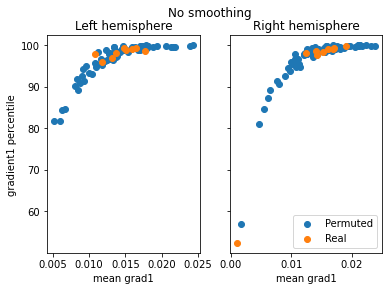

In [3]:
### Visualize real and null gradient percentiles

output_dir = "/home/fralberti/Data/Gradientile/"

gradientile_df = pd.read_csv(f'{output_dir}grad1entiles.csv')
perm_percentile_L = gradientile_df.loc[(gradientile_df.ID_vtx!=gradientile_df.ID_grad) & (gradientile_df.hemisphere=='L'),['mean','percentile']]
orig_percentile_L = gradientile_df.loc[(gradientile_df.ID_vtx==gradientile_df.ID_grad) & (gradientile_df.hemisphere=='L'),['mean','percentile']]
perm_percentile_R = gradientile_df.loc[(gradientile_df.ID_vtx!=gradientile_df.ID_grad) & (gradientile_df.hemisphere=='R'),['mean','percentile']]
orig_percentile_R = gradientile_df.loc[(gradientile_df.ID_vtx==gradientile_df.ID_grad) & (gradientile_df.hemisphere=='R'),['mean','percentile']]

fig1 , ax1 = plt.subplots(1,2,sharey=True)

ax1[0].scatter(perm_percentile_L['mean'], perm_percentile_L['percentile'])
ax1[0].scatter(orig_percentile_L['mean'], orig_percentile_L['percentile'])
ax1[0].set_xlabel('mean grad1')
ax1[0].set_ylabel('gradient1 percentile')
ax1[0].title.set_text('Left hemisphere')

ax1[1].scatter(perm_percentile_R['mean'], perm_percentile_R['percentile'])
ax1[1].scatter(orig_percentile_R['mean'], orig_percentile_R['percentile'])
ax1[1].set_xlabel('mean grad1')
ax1[1].legend(['Permuted','Real'])
ax1[1].title.set_text('Right hemisphere')
fig1 = fig1.suptitle('No smoothing')

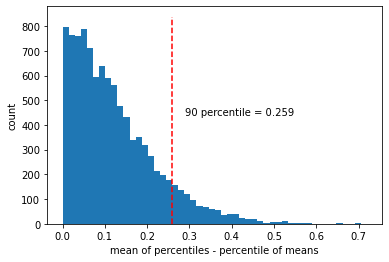

In [4]:
### Visualize difference between percentile of the mean grad1 vs the mean of the percentiles of each node
from scipy import stats
diff = []
for i in range(10000):
    X = np.random.uniform(low=-0.022, high=0.022,size=[32000])
    x = np.random.uniform(low=-0.022, high=0.022,size=[3])
    diff.append(abs(np.mean([stats.percentileofscore(X,i) for i in x])-stats.percentileofscore(X,np.mean(x))))

perc = 90
plot=plt.hist(diff,50)
np.percentile(diff,perc)
plot = plt.vlines(np.percentile(diff,perc),plt.ylim()[0],plt.ylim()[1],'r','--')
plot = plt.text(np.percentile(diff,perc)+0.03,plt.ylim()[1]/2,f'{perc} percentile = {np.percentile(diff,perc).round(3)}')
plot = plt.ylabel('count')
plot = plt.xlabel('mean of percentiles - percentile of means')
